# Implementing RNN, GRU, and LSTM for Movie Review Sentiment Analysis
> [Reference](https://regenerativetoday.com/implementation-of-simplernn-gru-and-lstm-models-in-keras-and-tensorflow-for-an-nlp-project/)

In [3]:
# !pip3 install tensorflow-datasets

In [4]:
# import libraries
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds # contains the movie review dataset

/Users/odemunoogelohwohor/Documents/GitHub/CMU_SPR23/deeplearning-examples/dlprojenv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
imdb, info = tfds.load("imdb_reviews", with_info=True, as_supervised=True)

2023-05-10 18:11:24.397210: W tensorflow/tsl/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata.google.internal".


Dl Completed...: 100%|██████████| 1/1 [00:36<00:00, 36.77s/ url]


Dataset imdb_reviews downloaded and prepared to /Users/odemunoogelohwohor/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [6]:
# see the datatype for the dataset and info
print(type(imdb))
print(type(info))

<class 'dict'>
<class 'tensorflow_datasets.core.dataset_info.DatasetInfo'>


In [7]:
# view part of the data
print(imdb)

{Split('train'): <_PrefetchDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>, Split('test'): <_PrefetchDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>, Split('unsupervised'): <_PrefetchDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>}


In [8]:
print(info)

tfds.core.DatasetInfo(
    name='imdb_reviews',
    full_name='imdb_reviews/plain_text/1.0.0',
    description="""
    Large Movie Review Dataset. This is a dataset for binary sentiment
    classification containing substantially more data than previous benchmark
    datasets. We provide a set of 25,000 highly polar movie reviews for training,
    and 25,000 for testing. There is additional unlabeled data for use as well.
    """,
    config_description="""
    Plain text
    """,
    homepage='http://ai.stanford.edu/~amaas/data/sentiment/',
    data_path=PosixGPath('/var/folders/cf/28wm9krx5816hxprmj3lstxh0000gn/T/tmp9_95x9a8tfds'),
    file_format=tfrecord,
    download_size=80.23 MiB,
    dataset_size=129.83 MiB,
    features=FeaturesDict({
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
        'text': Text(shape=(), dtype=string),
    }),
    supervised_keys=('text', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=2500

In [9]:
train_data, test_data = imdb['train'], imdb['test']

## Data Preprocessing

In [10]:
# load data into lists
training_sentences = []
training_labels = []
testing_sentences = []
testing_labels = []
for s,l in train_data:
    training_sentences.append(str(s.numpy()))
    training_labels.append(l.numpy())
for s,l in test_data:
    testing_sentences.append(str(s.numpy()))
    testing_labels.append(l.numpy())

2023-05-10 18:14:54.237526: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int64 and shape [1]
	 [[{{node Placeholder/_4}}]]
2023-05-10 18:14:54.238307: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int64 and shape [1]
	 [[{{node Placeholder/_4}}]]
2023-05-10 18:14:59.862431: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{nod

In [19]:
# read one of the sentences
training_sentences[0]

'b"This was an absolutely terrible movie. Don\'t be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie\'s ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor\'s like Christopher Walken\'s good name. I could barely sit through it."'

In [11]:
# convert to np arrays
training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)

In [12]:
training_labels_final

array([0, 0, 0, ..., 0, 0, 1])

In [13]:
# model parameters
# if the IMDB dataset has more than 10000 words, extra words will not be used to train the model
vocab_size = 10000 

# size of the vector that will be used to represent each word
embedding_dim = 16

# maximum length of 120 words will be used for each piece of text or to predict a label
max_length = 120

# text will be truncated at the end
trunc_type = 'post'

# if there is an unknown word that will be represented by oov_tok
oov_tok = ""

In [18]:
# tokenize the texts
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index

# print first 20 key-value pairs
print("length of word_index: ", len(list(word_index.items())))
print("-"*30)
print(str(dict(list(word_index.items())[0:20])))

length of word_index:  86539
------------------------------
{'': 1, 'the': 2, 'and': 3, 'a': 4, 'of': 5, 'to': 6, 'is': 7, 'br': 8, 'in': 9, 'it': 10, 'i': 11, 'this': 12, 'that': 13, 'was': 14, 'as': 15, 'for': 16, 'with': 17, 'movie': 18, 'but': 19, 'film': 20}


We will arrange our sentences using these integer values instead of words. Also, padding would be used if the sentences are less than the set max_length 120 words.



In [20]:
# train
sequences = tokenizer.texts_to_sequences(training_sentences)
padded = pad_sequences(sequences, maxlen=max_length, truncating=trunc_type)

# test
testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length)

In [22]:
print(training_sentences[0])

b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."


In [21]:
print(sequences[0])

[59, 12, 14, 35, 439, 400, 18, 174, 29, 1, 9, 33, 1378, 3401, 42, 496, 1, 197, 25, 88, 156, 19, 12, 211, 340, 29, 70, 248, 213, 9, 486, 62, 70, 88, 116, 99, 24, 5740, 12, 3317, 657, 777, 12, 18, 7, 35, 406, 8228, 178, 2477, 426, 2, 92, 1253, 140, 72, 149, 55, 2, 1, 7525, 72, 229, 70, 2962, 16, 1, 2880, 1, 1, 1506, 4998, 3, 40, 3947, 119, 1608, 17, 3401, 14, 163, 19, 4, 1253, 927, 7986, 9, 4, 18, 13, 14, 4200, 5, 102, 148, 1237, 11, 240, 692, 13, 44, 25, 101, 39, 12, 7232, 1, 39, 1378, 1, 52, 409, 11, 99, 1214, 874, 145, 10]


This resulting sequences of integers can be used as input to a neural network for training or prediction, since neural networks generally require input data to be in the form of numerical arrays rather than text.

## RNN Model

In [23]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim,input_length=max_length),
    tf.keras.layers.SimpleRNN(32),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 120, 16)           160000    
                                                                 
 simple_rnn (SimpleRNN)      (None, 32)                1568      
                                                                 
 dense (Dense)               (None, 10)                330       
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 161,909
Trainable params: 161,909
Non-trainable params: 0
_________________________________________________________________


In [24]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [25]:
num_epochs = 30
history = model.fit(padded, training_labels_final, 
                  epochs=num_epochs, validation_data = (testing_padded, testing_labels_final))

Epoch 1/30
782/782 [==============================] - 23s 27ms/step - loss: 0.6930 - accuracy: 0.5148 - val_loss: 0.6855 - val_accuracy: 0.5663
Epoch 2/30
782/782 [==============================] - 23s 29ms/step - loss: 0.5998 - accuracy: 0.6728 - val_loss: 0.6720 - val_accuracy: 0.5750
Epoch 3/30
782/782 [==============================] - 23s 29ms/step - loss: 0.5217 - accuracy: 0.7380 - val_loss: 0.4969 - val_accuracy: 0.7653
Epoch 4/30
782/782 [==============================] - 21s 27ms/step - loss: 0.2914 - accuracy: 0.8822 - val_loss: 0.5408 - val_accuracy: 0.7900
Epoch 5/30
782/782 [==============================] - 20s 26ms/step - loss: 0.1895 - accuracy: 0.9288 - val_loss: 0.6490 - val_accuracy: 0.7853
Epoch 6/30
782/782 [==============================] - 20s 26ms/step - loss: 0.0908 - accuracy: 0.9686 - val_loss: 0.8555 - val_accuracy: 0.7460
Epoch 7/30
782/782 [==============================] - 20s 26ms/step - loss: 0.0562 - accuracy: 0.9814 - val_loss: 1.0458 - val_accuracy:

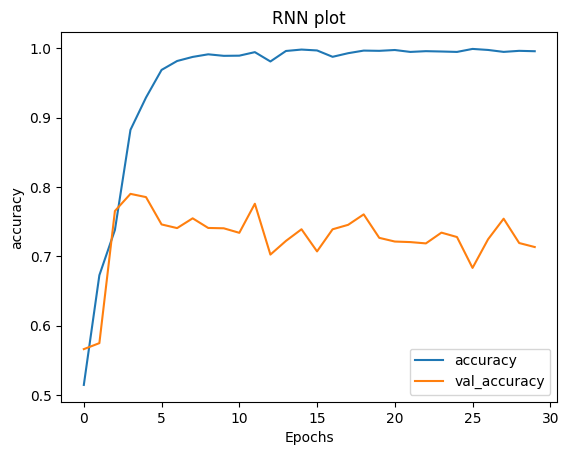

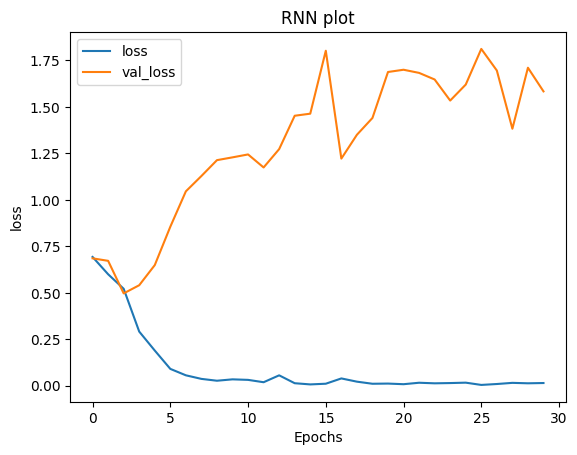

In [27]:
import matplotlib.pyplot as plt

def plot_graphs(history, string, model_name):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.title(model_name + " plot")
    plt.legend([string, 'val_'+string])
    plt.show()
    
plot_graphs(history, 'accuracy', 'RNN')
plot_graphs(history, 'loss', 'RNN')

# GRU Model

In [28]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim,
                             input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32)),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

2023-05-10 18:40:18.215596: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-10 18:40:18.217417: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-10 18:40:18.219167: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 120, 16)           160000    
                                                                 
 bidirectional (Bidirectiona  (None, 64)               9600      
 l)                                                              
                                                                 
 dense_2 (Dense)             (None, 10)                650       
                                                                 
 dense_3 (Dense)             (None, 1)                 11        
                                                                 
Total params: 170,261
Trainable params: 170,261
Non-trainable params: 0
_________________________________________________________________


2023-05-10 18:40:18.433844: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-10 18:40:18.435806: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-10 18:40:18.437263: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [29]:
model.compile(loss="binary_crossentropy", optimizer='adam', metrics=['accuracy'])

In [30]:
history = model.fit(padded, training_labels_final, epochs=num_epochs,
                    validation_data = (testing_padded,testing_labels_final))

Epoch 1/30


2023-05-10 18:40:36.631379: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-10 18:40:36.633202: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-10 18:40:36.635108: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

782/782 [==============================] - ETA: 0s - loss: 0.5221 - accuracy: 0.7077

2023-05-10 18:41:25.379791: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-10 18:41:25.381811: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-10 18:41:25.383734: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

782/782 [==============================] - 57s 66ms/step - loss: 0.5221 - accuracy: 0.7077 - val_loss: 0.3542 - val_accuracy: 0.8440
Epoch 2/30
782/782 [==============================] - 48s 61ms/step - loss: 0.3020 - accuracy: 0.8746 - val_loss: 0.3574 - val_accuracy: 0.8420
Epoch 3/30
782/782 [==============================] - 43s 55ms/step - loss: 0.2382 - accuracy: 0.9077 - val_loss: 0.4031 - val_accuracy: 0.8295
Epoch 4/30
782/782 [==============================] - 39s 50ms/step - loss: 0.1860 - accuracy: 0.9318 - val_loss: 0.4153 - val_accuracy: 0.8280
Epoch 5/30
782/782 [==============================] - 36s 46ms/step - loss: 0.1411 - accuracy: 0.9504 - val_loss: 0.4336 - val_accuracy: 0.8205
Epoch 6/30
782/782 [==============================] - 36s 46ms/step - loss: 0.1012 - accuracy: 0.9663 - val_loss: 0.5502 - val_accuracy: 0.8194
Epoch 7/30
782/782 [==============================] - 37s 47ms/step - loss: 0.0650 - accuracy: 0.9792 - val_loss: 0.6980 - val_accuracy: 0.8082
Epo

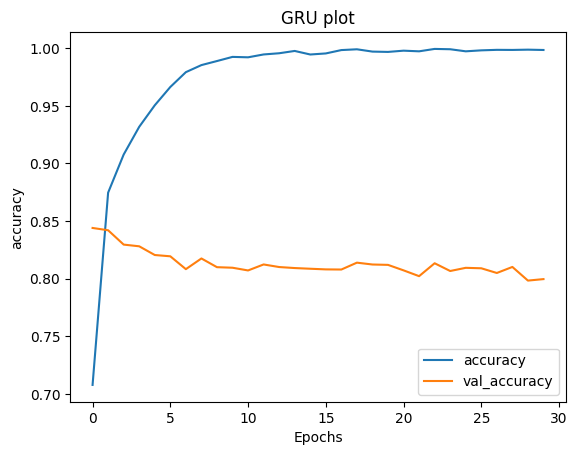

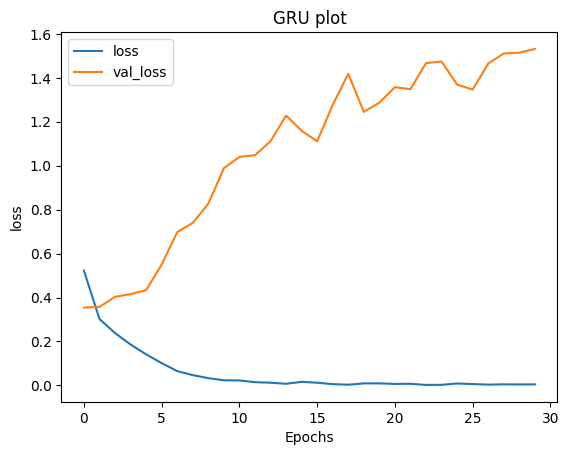

In [31]:
plot_graphs(history, 'accuracy', 'GRU')
plot_graphs(history, 'loss', 'GRU')

# LSTM Model

In [32]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

2023-05-10 19:06:05.670640: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-10 19:06:05.672375: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-10 19:06:05.674385: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 120, 16)           160000    
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               12544     
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 10)                650       
                                                                 
 dense_5 (Dense)             (None, 1)                 11        
                                                                 
Total params: 173,205
Trainable params: 173,205
Non-trainable params: 0
_________________________________________________________________


2023-05-10 19:06:05.923986: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-10 19:06:05.926130: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-10 19:06:05.927633: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [33]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [34]:
history = model.fit(padded, training_labels_final, epochs=num_epochs, 
                    validation_data = (testing_padded, testing_labels_final))

Epoch 1/30


2023-05-10 19:06:14.425132: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-10 19:06:14.427221: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-10 19:06:14.429955: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

782/782 [==============================] - ETA: 0s - loss: 0.5607 - accuracy: 0.7048

2023-05-10 19:06:49.092968: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-10 19:06:49.095008: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-10 19:06:49.096529: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

782/782 [==============================] - 43s 50ms/step - loss: 0.5607 - accuracy: 0.7048 - val_loss: 0.4779 - val_accuracy: 0.8076
Epoch 2/30
782/782 [==============================] - 41s 52ms/step - loss: 0.3457 - accuracy: 0.8582 - val_loss: 0.3795 - val_accuracy: 0.8352
Epoch 3/30
782/782 [==============================] - 39s 50ms/step - loss: 0.2685 - accuracy: 0.8964 - val_loss: 0.4364 - val_accuracy: 0.8277
Epoch 4/30
782/782 [==============================] - 37s 48ms/step - loss: 0.2236 - accuracy: 0.9179 - val_loss: 0.4152 - val_accuracy: 0.8352
Epoch 5/30
782/782 [==============================] - 38s 49ms/step - loss: 0.1861 - accuracy: 0.9326 - val_loss: 0.4420 - val_accuracy: 0.8319
Epoch 6/30
782/782 [==============================] - 39s 49ms/step - loss: 0.1545 - accuracy: 0.9465 - val_loss: 0.5822 - val_accuracy: 0.8180
Epoch 7/30
782/782 [==============================] - 38s 49ms/step - loss: 0.1305 - accuracy: 0.9566 - val_loss: 0.5912 - val_accuracy: 0.8230
Epo

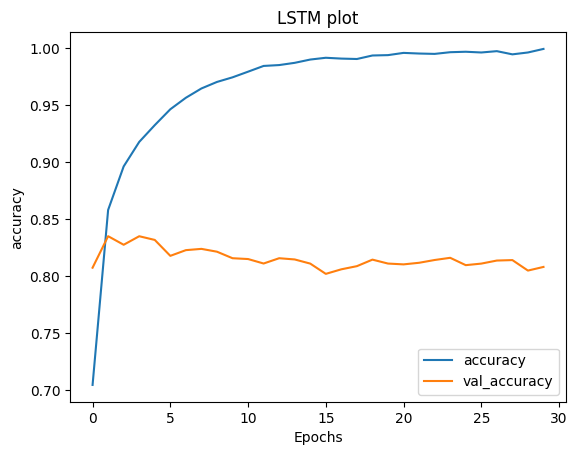

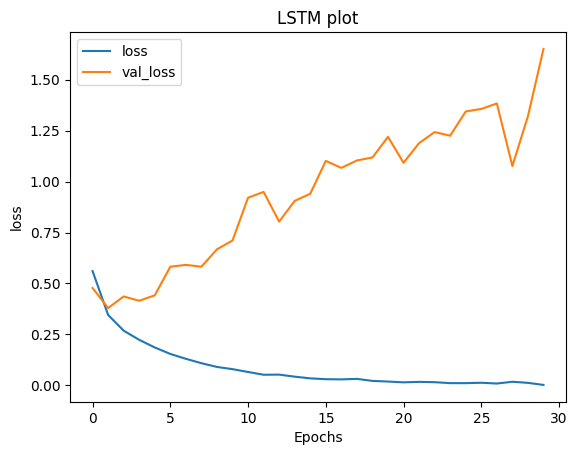

In [35]:
plot_graphs(history, 'accuracy', 'LSTM')
plot_graphs(history, 'loss', 'LSTM')